# Neural Network Implementation

In [50]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, Imputer
from sklearn.utils import class_weight
#from category_encoders.hashing import HashingEncoder

from keras.layers import BatchNormalization, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)
train.head(2)

(307511, 199)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,B_AMT_ANNUITY,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_COUNT,MONTHS_MIN,MONTHS_MAX,BUREAU_CNT,PREV_APP_AMT_ANNUITY,AMT_APPLICATION,P_AMT_CREDIT,AMT_DOWN_PAYMENT,P_AMT_GOODS_PRICE,P_HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_APPS,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NUNIQUE_STATUS,CC_MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,CC_NUNIQUE_STATUS,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833

In [4]:
test = pd.read_csv('input/test.csv')
print(test.shape)
test.head(2)

(48744, 198)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,B_AMT_ANNUITY,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_COUNT,MONTHS_MIN,MONTHS_MAX,BUREAU_CNT,PREV_APP_AMT_ANNUITY,AMT_APPLICATION,P_AMT_CREDIT,AMT_DOWN_PAYMENT,P_AMT_GOODS_PRICE,P_HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_APPS,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NUNIQUE_STATUS,CC_MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,CC_NUNIQUE_STATUS,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.066,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.059,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0

## Preprocessing

Removing service columns

In [5]:
targets = train[['TARGET']]
train_size = train.shape[0]
#train.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)
train.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [7]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()
set(train_cols).symmetric_difference(train_cols)

set()

In [8]:
data = pd.concat([train, test])

In [9]:
print(data.shape)
data.head(2)

(356255, 197)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,B_AMT_ANNUITY,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_COUNT,MONTHS_MIN,MONTHS_MAX,BUREAU_CNT,PREV_APP_AMT_ANNUITY,AMT_APPLICATION,P_AMT_CREDIT,AMT_DOWN_PAYMENT,P_AMT_GOODS_PRICE,P_HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_APPS,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NUNIQUE_STATUS,CC_MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,CC_NUNIQUE_STATUS,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198

Removing columns where too many missing values

In [10]:
missing_vals = compute_missing_values(data)
to_remove = idx_of_missing_values(missing_vals)
data.drop(columns=to_remove, inplace=True)

Categorical Features

In [11]:
data = pd.get_dummies(data)

Numerical Features Imputation

In [12]:
numerical = data.select_dtypes('float64').columns.tolist()

In [13]:
# median, so we do not that sensitive to outliers
imputer = Imputer(strategy='median')
data[numerical] = imputer.fit_transform(data[numerical])

Features Normalization

In [14]:
scaler = MinMaxScaler()
data[numerical] = scaler.fit_transform(data[numerical])

Computing class weights

In [33]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(targets), targets['TARGET'])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5439091430067283, 1: 6.193575025176234}

## Model

In [41]:
X_train = data.iloc[:train_size]
X_test = data.iloc[train_size:]

In [46]:
model = Sequential()
model.add(Dense(512, input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(LeakyReLU())

# model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(LeakyReLU())

# model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(LeakyReLU())

# model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               161792    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total para

In [47]:
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [48]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=0, mode='auto')

hist = model.fit(x=X_train, y=targets,
                 batch_size=128, epochs=1,
                 verbose=1, callbacks=[checkpointer, earlystop],
                 class_weight=class_weights)

model.save_weights('model.weights.latest.hdf5')

# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/1
307511/307511 [==============================] - 15s 49us/step - loss: 0.6839 - binary_accuracy: 0.5132


In [53]:
hist.history

{'binary_accuracy': [0.513220665276433], 'loss': [0.6839381881902173]}

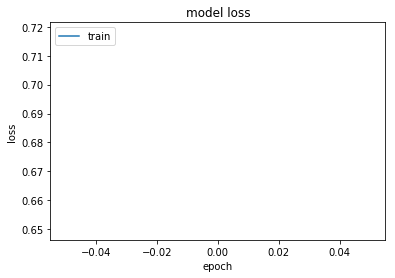

In [54]:
plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Predictions

In [58]:
#model.load_weights('model.weights.best.hdf5')
model.load_weights('model.weights.latest.hdf5')
y_pred = model.predict(X_test, batch_size=128, verbose=1)

48744/48744 [==============================] - 0s 6us/step


In [65]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': y_pred[:,0]})
save_prediction(submission, 'NN_MLP')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-NN_MLP.csv -m "NN_MLP"'